In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import butter, sosfiltfilt, resample
from scipy.interpolate import interp1d

def load_muse_data(file_path):
    
    column_names = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
    df = pd.read_csv(
        file_path, 
        sep='\t', 
        names=column_names, 
        engine='python', 
        on_bad_lines='warn'
    )
    df['data'] = df['data'].apply(lambda x: list(map(float, x.split(','))))
    return df

def butter_bandpass(lowcut, highcut, fs, order=4):
    """Butterworth bandpass filter design using SOS [3][10][14]"""
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    sos = butter(order, [low, high], btype='band', output='sos')
    return sos

def apply_filter(data, lowcut=0.5, highcut=50.0, fs=256, order=4):
    """Zero-phase filtering with SOS implementation [10][14]"""
    sos = butter_bandpass(lowcut, highcut, fs, order=order)
    filtered = sosfiltfilt(sos, data)
    return filtered

def preprocess_pipeline(df, fs=256):
    """Complete preprocessing pipeline for Muse EEG data"""
    
    # Step 1: Apply bandpass filter to all channels [10][14]
    print("Applying bandpass filter (0.5-50Hz)...")
    df['filtered'] = df['data'].apply(
        lambda x: apply_filter(x, fs=fs)
    )

    # Step 2: Epoch processing [7][11]
    print("Segmenting and cleaning epochs...")
    
    # Group by stimulus code (0-9), exclude random signals (-1)
    valid_codes = [str(i) for i in range(10)]
    epochs = df[df['code'].astype(str).isin(valid_codes)].groupby('code')
    
    processed_data = []
    for code, group in epochs:
        # Calculate median epoch length [5]
        lengths = group['filtered'].apply(len)
        median_length = int(lengths.median())
        
        # Resample to median length [4]
        resampled = group['filtered'].apply(
            lambda x: resample(x, median_length) if len(x) > 10 else x
        )
        
        # NaN handling with linear interpolation [6]
        cleaned = resampled.apply(
            lambda x: interp1d(np.linspace(0, 1, len(x)), x, 
                             fill_value='extrapolate')(np.linspace(0, 1, median_length))
            if np.isnan(x).any() else x
        )
        
        # Channel-wise z-score normalization [16][19]
        normalized = cleaned.apply(
            lambda x: (x - np.nanmean(x)) / np.nanstd(x) if np.nanstd(x) != 0 else x
        )
        
        # Store processed epoch with metadata
        for idx, row in normalized.items():
            processed_data.append({
                'id': df.loc[idx, 'id'],
                'code': code,
                'channel': df.loc[idx, 'channel'],
                'data': row,
                'duration': 2.0,
                'sampling_rate': fs
            })

    return pd.DataFrame(processed_data)

if __name__ == "__main__":
    # Example usage
    raw_data = load_muse_data('MU.txt')
    
    # Validate data loading
    print("\nRaw Data Sample:")
    print(f"Columns: {raw_data.columns.tolist()}")
    print(f"First data point length: {len(raw_data.iloc[0]['data'])}")
    
    # Run preprocessing
    processed_df = preprocess_pipeline(raw_data)
    
    # Output results
    print("\nPreprocessing Complete:")
    print(f"Total Epochs: {len(processed_df)}")
    print("Channel Distribution:")
    print(processed_df['channel'].value_counts())
    print("\nSample Processed Epoch:")
    sample = processed_df.iloc[0]
    print(f"ID: {sample['id']} | Code: {sample['code']}")
    print(f"Channel: {sample['channel']} | Length: {len(sample['data'])}")
    print(f"Mean: {np.mean(sample['data']):.4f} | STD: {np.std(sample['data']):.4f}")



Raw Data Sample:
Columns: ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
First data point length: 459
Applying bandpass filter (0.5-50Hz)...
Segmenting and cleaning epochs...

Preprocessing Complete:
Total Epochs: 119520
Channel Distribution:
channel
TP9     29880
FP1     29880
FP2     29880
TP10    29880
Name: count, dtype: int64

Sample Processed Epoch:
ID: 978171 | Code: 0
Channel: TP9 | Length: 476
Mean: 0.0000 | STD: 1.0000


Applying bandpass filter (0.5-50Hz)...
Segmenting and cleaning epochs...


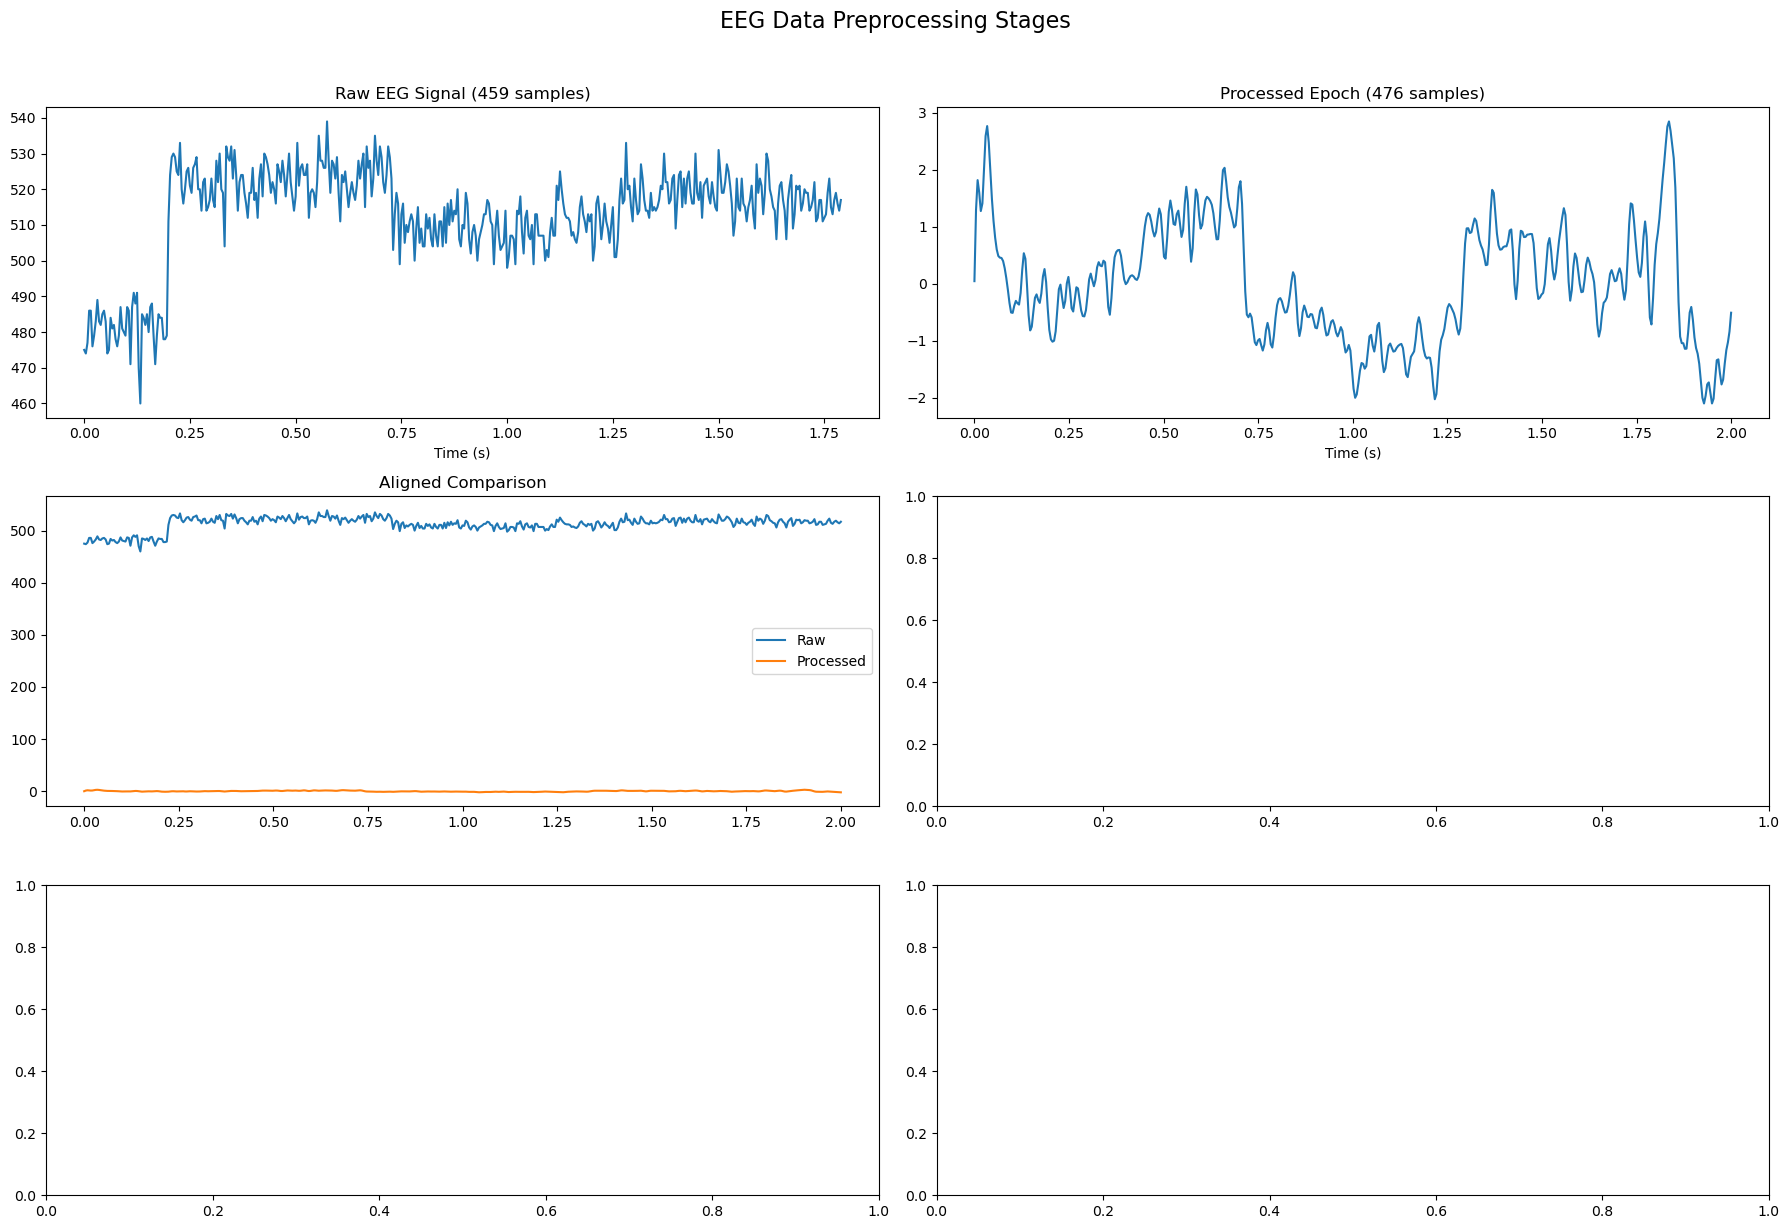

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import resample

def plot_preprocessing_steps(raw_data, processed_data, fs=256):
    fig, axs = plt.subplots(3, 2, figsize=(18, 12))
    fig.suptitle('EEG Data Preprocessing Stages', y=1.02, fontsize=16)
    
    # Raw data plotting with correct time axis
    raw_samples = len(raw_data['data'].iloc[0])
    raw_time = np.arange(raw_samples)/fs
    axs[0,0].plot(raw_time, raw_data['data'].iloc[0])
    axs[0,0].set_title(f'Raw EEG Signal ({raw_samples} samples)')
    axs[0,0].set_xlabel('Time (s)')
    
    # Processed data plotting with its own time axis
    processed_samples = len(processed_df.iloc[0]['data'])
    processed_time = np.linspace(0, 2, processed_samples)
    axs[0,1].plot(processed_time, processed_df.iloc[0]['data'])
    axs[0,1].set_title(f'Processed Epoch ({processed_samples} samples)')
    axs[0,1].set_xlabel('Time (s)')
    
    # Common time axis for comparison plots
    min_length = min(raw_samples, processed_samples)
    common_time = np.linspace(0, 2, min_length)
    
    # Comparison plot with aligned lengths
    axs[1,0].plot(common_time, raw_data['data'].iloc[0][:min_length], 
                label='Raw')
    axs[1,0].plot(common_time, processed_df.iloc[0]['data'][:min_length],
                label='Processed')
    axs[1,0].set_title('Aligned Comparison')
    axs[1,0].legend()
    
    plt.tight_layout()
    plt.show()


# Example usage
raw_data = load_muse_data('MU.txt')
processed_df = preprocess_pipeline(raw_data)

plot_preprocessing_steps(raw_data, processed_df)
